<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo file
Authors: Michal Bělohlávek, Tomáš Procházka
## Intro
Welcome to the demo file, where one can run the project with zero effort and see the results and visualistaion for themselves. While this is an easy and plesant way to enjoy this Neural Net, we strongly urge anyone who visits this demo to run the project as it was intended, expand upon it and improve it.

## Abstract
This project was created and submited as the final semestral project for the Machine Learning 2 class on FNSPE CTU. This project concerns itself with reinforcement learning for multiple agents controlled by a single neural net in a graph environment. The core aim of this project is to provide a neural network solution that efficiently navigates multiple planes along a fully connected graph with the goal of estimating the shortest path, while avoiding collisions of planes. We implemented an enhanced version of a classical replay buffer that samples experiences based on the predicted future reward to assist the learning process. We also implemented regularization techniques, since the dimensionality of our problem is much larger compared to the problems in the repository we cite.

## Overview of the Used Machine Learning Techniques

## How to Run the Project


In [17]:
!git clone https://github.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/

Cloning into '2024-final-letadylka-prochazka-belohlavek'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 423 (delta 95), reused 114 (delta 60), pack-reused 226 (from 1)
Receiving objects: 100% (423/423), 10.59 MiB | 19.54 MiB/s, done.
Resolving deltas: 100% (197/197), done.


In [ ]:
# Run the main.py script with the modified config
!python /content/2024-final-letadylka-prochazka-belohlavek/src/main.py --config data/config_comm.yaml

2024-12-12 10:11:59.841513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 10:11:59.878132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 10:11:59.887487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 10:11:59.924750: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

A module that was compiled using NumPy 1.x cannot be

Download files from our Git repository




In [ ]:
# Download the network.py file from GitHub
!wget -q https://raw.githubusercontent.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/main/src/environment.py

!wget -q https://raw.githubusercontent.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/main/src/eval.py

!wget -q https://raw.githubusercontent.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/main/src/network.py

!wget -q https://raw.githubusercontent.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/main/src/routing.py

!wget -q https://raw.githubusercontent.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/main/src/policy.py

!wget -q https://raw.githubusercontent.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/main/src/model.py

!wget -q https://raw.githubusercontent.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/main/src/wrapper.py

!wget -q https://github.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/tree/main/data/adj_mat_fixed.npy

!wget -q https://github.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/tree/main/data/dist_mat_fixed.npy

!wget -q https://github.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/tree/main/data/sparse_points_fixed.json

!wget -q https://github.com/Strojove-uceni/2024-final-letadylka-prochazka-belohlavek/blob/main/src/config.yaml

!pip install pyyaml

Import the files

In [ ]:
import numpy as np
import json

adj_mat = np.load('adj_mat_fixed.npy')
dist_mat = np.load('dist_mat_fixed')
with open('sparse_points_fixed.json', 'r') as file:
    sparse_points = json.load(file)

import yaml

with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

main.py adjusted for evaluation only

In [ ]:
from network import Network
from environment import reset_and_get_sizes

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import copy
import traceback
import json
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

from model import DGN, MLP, CommNet, NetMon, DQN
from routing import Routing

from wrapper import NetMonWrapper
from policy import ShortestPath, EpsilonGreedy
from pathlib import Path
from torch.utils.tensorboard.writer import SummaryWriter
from util import (
    dim_str_to_list,
    filter_dict,
    get_state_dict,
    interpolate_model,
    load_state_dict,
    set_attributes,
    set_seed,
)
from eval import evaluate
import sys
from torch.utils.tensorboard.writer import SummaryWriter

In [ ]:
# Normalize distance matrix
dist_mat[adj_mat==0] = 0
min = 1000
for i in range(118):
    for j in range(118):
        if 0< dist_mat[i][j] < min:
            min = dist_mat[i][j]
max = np.max(dist_mat)

new_min = 1
new_max = 10
dist_mat = ((dist_mat-min)/(max-min))*(new_max-new_min) + new_min

config['only_eval']['eval'] = True # overwrite any setting to evaluate only
if config['only_eval']['eval']:
    assert Path(config['only_eval']['model_path']).exists()
    loaded_dict = torch.load(config['only_eval']['model_path'], map_location='cpu')
    loaded_model_arg_values = loaded_dict["args"]
    loaded_model_arg_values['only_eval'] = {}
    loaded_model_arg_values['only_eval']['eval'] = True
    loaded_model_arg_values['only_eval']['model_path'] = config['only_eval']['model_path']
    config = loaded_model_arg_values
    config['evaluation']['episodes'] = 10
    config['evaluation']['episode_steps'] = 100
    config['training']['mini_batch_size'] = 8
    config['training']['sequence_length'] = 5
    config['netmon']['iterations'] = 3
    config['device'] = 'cpu'
    for key in config:
        if key == "device":
            print(f"{key}:  {config[key]}")
            continue
        print(key)
        for subkey in config[key]:
            print(f"\t{subkey}: {config[key][subkey]}")

cbase = config['base']
cnetmon = config['netmon']
device = config['device']
ctar_update = config['target_update']
ceval = config['evaluation']
ctraining = config['training']
ceps = config['epsilon_greedy']

# Define network environment
network = Network(adj_mat, dist_mat, sparse_points)


# Define type of environment
env = Routing(network, cbase['n_planes'], cbase['env_var'], adj_mat, dist_mat, k=cbase['n_neighbors'], enable_action_mask=False)

# Define activation function
activation_function = getattr(F, cbase['activ_f'])

# Dynamically resets the environment
n_agents, agent_obs_size, n_nodes, node_obs_size = reset_and_get_sizes(env)

print("Sizes before netmon:")
print("Agent observation size: ", agent_obs_size)
print("Node observation size: ", node_obs_size)

# Use NetMon - init is rather long :)
netmon = NetMon(node_obs_size,  # 'in_features' in init
                cnetmon['dim'],     # 'hidden_features' in init
                cnetmon['enc_dim'] , # 'encoder_units' in init
                iterations=cnetmon['iterations'],
                activation_fn=activation_function,
                rnn_type= cnetmon['rnn_type'], rnn_carryover=cnetmon['rnn_carryover'], agg_type=cnetmon['agg_type'],
                output_neighbor_hidden=cnetmon['neighbor'], output_global_hidden=cnetmon['global']
                ).to(device)    # Move to device


# Get observations from the environment
summary_node_obs = torch.tensor(env.get_node_observation(), dtype=torch.float32, device=device).unsqueeze(0)
summary_node_adj = torch.tensor(env.get_nodes_adjacency(), dtype=torch.float32, device=device).unsqueeze(0)
summary_node_agent = torch.tensor(env.get_node_agent_matrix(), dtype=torch.float32, device=device).unsqueeze(0)
# Summarizes our current model - just to have it somewhere
netmon_summary = netmon.summarize(summary_node_obs, summary_node_adj, summary_node_agent)
node_state_size = netmon.get_state_size()

node_aux_size = 0 if env.get_node_aux() is None else len(env.get_node_aux()[0]) # = n_waypoints

# Now we wrap the whole netmon class with a Wrapper - agents will use observations from netmon
env = NetMonWrapper(env, netmon, cnetmon['start_up_iters'])
_, agent_obs_size, _, _ = reset_and_get_sizes(env)  # Observation length

print("Sizes after netmon:")
print(f"Node state size: {node_state_size}")        # 256
print(f"Agent observation size with netmon: {agent_obs_size}")  # 3263
print(f"Node auxiliary size: {node_aux_size}")      # 0



# In_features are 'agent_obs_size'
# 'env.action_space.n' is equal to the number of neighbors - choices, 'num_actions' in DGN definition
cdgn = config['dgn']
if cbase['model_type'] == "dgn":
    model = DGN(agent_obs_size, cdgn['hidden_dim'], env.action_space.n, cdgn['heads'], cdgn['att_layers'], activation_function, cdgn['kv_values']).to(device)
elif cbase['model_type'] == "comm_net":
    ccom_net = config['commnet']
    model = CommNet(agent_obs_size, cdgn['hidden_dim'], env.action_space.n, comm_rounds=ccom_net['comm_rounds'], activation_fn=activation_function).to(device)
elif cbase['model_type'] == "dqn":
    model = DQN(agent_obs_size, cdgn['hidden_dim'], env.action_space.n, activation_function).to(device)
else:
    raise ValueError("Invalid model type")


# print(config)
# Load paramters of model for quick evaluation
if config['only_eval']['eval']:
    assert Path(config['only_eval']['model_path']).exists()
    load_state_dict(
        torch.load(config['only_eval']['model_path'], map_location=device),
        model,
        netmon,
    )


In [ ]:
model_tar = copy.deepcopy(model).to(device)     # Create a deep copy of the current model == DGN

model = model.load_state_dict(torch.load('model.pth'))
model_has_state = hasattr(model, "state")
aux_model = None

policy = EpsilonGreedy(env, model, env.action_space.n, epsilon=ceps['epsilon'], step_before_train=ctraining['step_before_train'], epsilon_update_freq=ceps['epsilon_update_freq'], epsilon_decay=ceps['epsilon_decay'])

if config['only_eval']['eval']:
    model.eval()
    netmon.eval()
    print("loaded")
    print("Performing Evaluation")
    metrics = evaluate(env, policy, ceval['episodes'], ceval['episode_steps'],
                      True, "eval_dict", ceval['output_detailed'], ceval['output_node_state_aux']
                      )
    print(json.dumps(metrics, indent=4, sort_keys=True, default=str))
    sys.exit(0)

In [ ]:
# Evaluate
comment = "_"
if hasattr(env, "env_var"):
    comment += f"R{env.env_var.value}"
comment += "_netmon"
writer = SummaryWriter(comment=comment)
print("Performing evaluation:")
metrics = evaluate(
    env,
    policy,
    ceval['episodes'],
    ceval['episode_steps'],
    Path(writer.get_logdir()) /"eval",
    ceval['output_detailed'],
    ceval['output_node_state_aux']
)
paths_to_save = env.save_paths()
print(json.dumps(metrics, indent = 4, sort_keys=True, default=str))

for plane in env.planes:
    print(plane.paths)

env.plot_trajectory()

### Selecting Parameters
We ran multiple sweeps on Weights & Biases to provide an overview of the parameter importance and correlations. Because of the time constraints for the project, we were not able to collect all the data we would like but regardless the results are reasonably clear. We selected the BEST models based on the gathered reward. Other interesting metrics would be spr (the mean ratio of the lenght of the path taken and the true shortest path) or throughput (mean ratio of the planes that reached the target during the episode).

We ran two sweeps, one for only CommNet settings (first picture), the other sweep for comparing DQN and DGN (second picture). Both sweeps ran for 75k steps, with CommNet being significantly faster yet inferior architecture and Sum being the superior AND faster aggregation method.

# Common Parameters in the Sweep
 - mini_batch_size : number of sampled experiences from the replay buffer
 - epsilon_decay : decay factor of epsilon in the EpsilonGreedy policy
 - agg_type : method used during GNN message aggregation phase
 - gamma: multiplicative factor in Q-Learning

# CommNet specific
 - comm_round: number of information passing round

# DQN, DGN specific
 - num_heads: number of attention heads



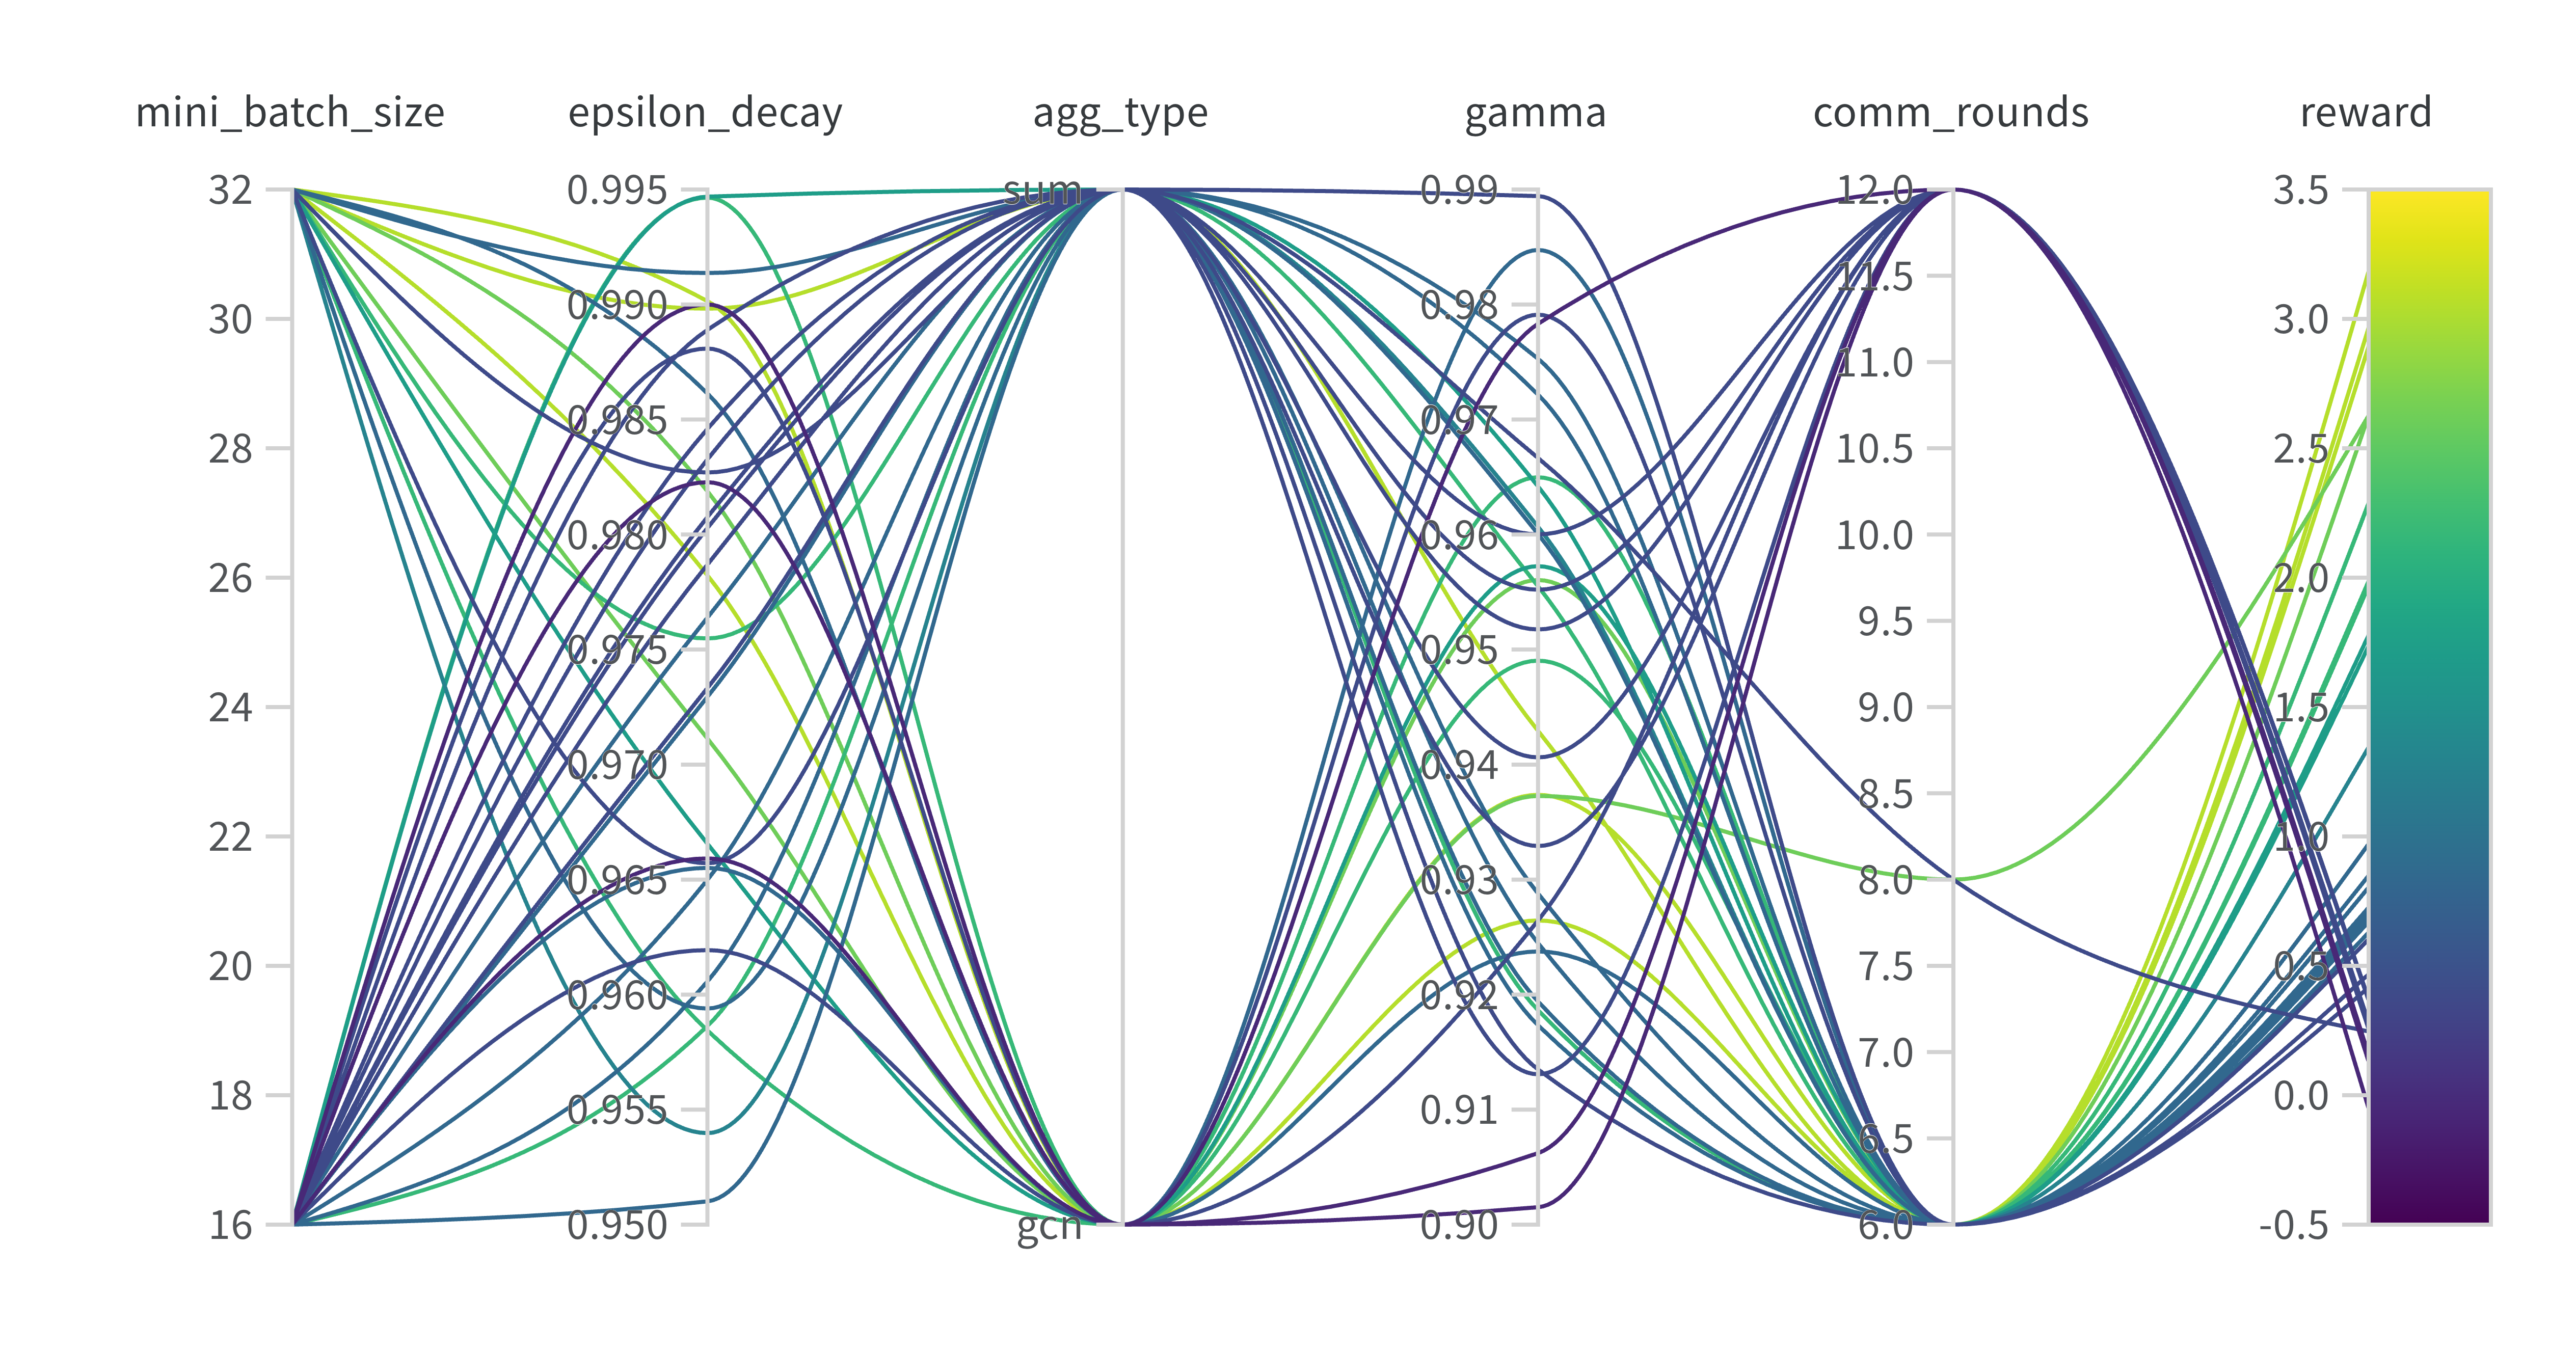

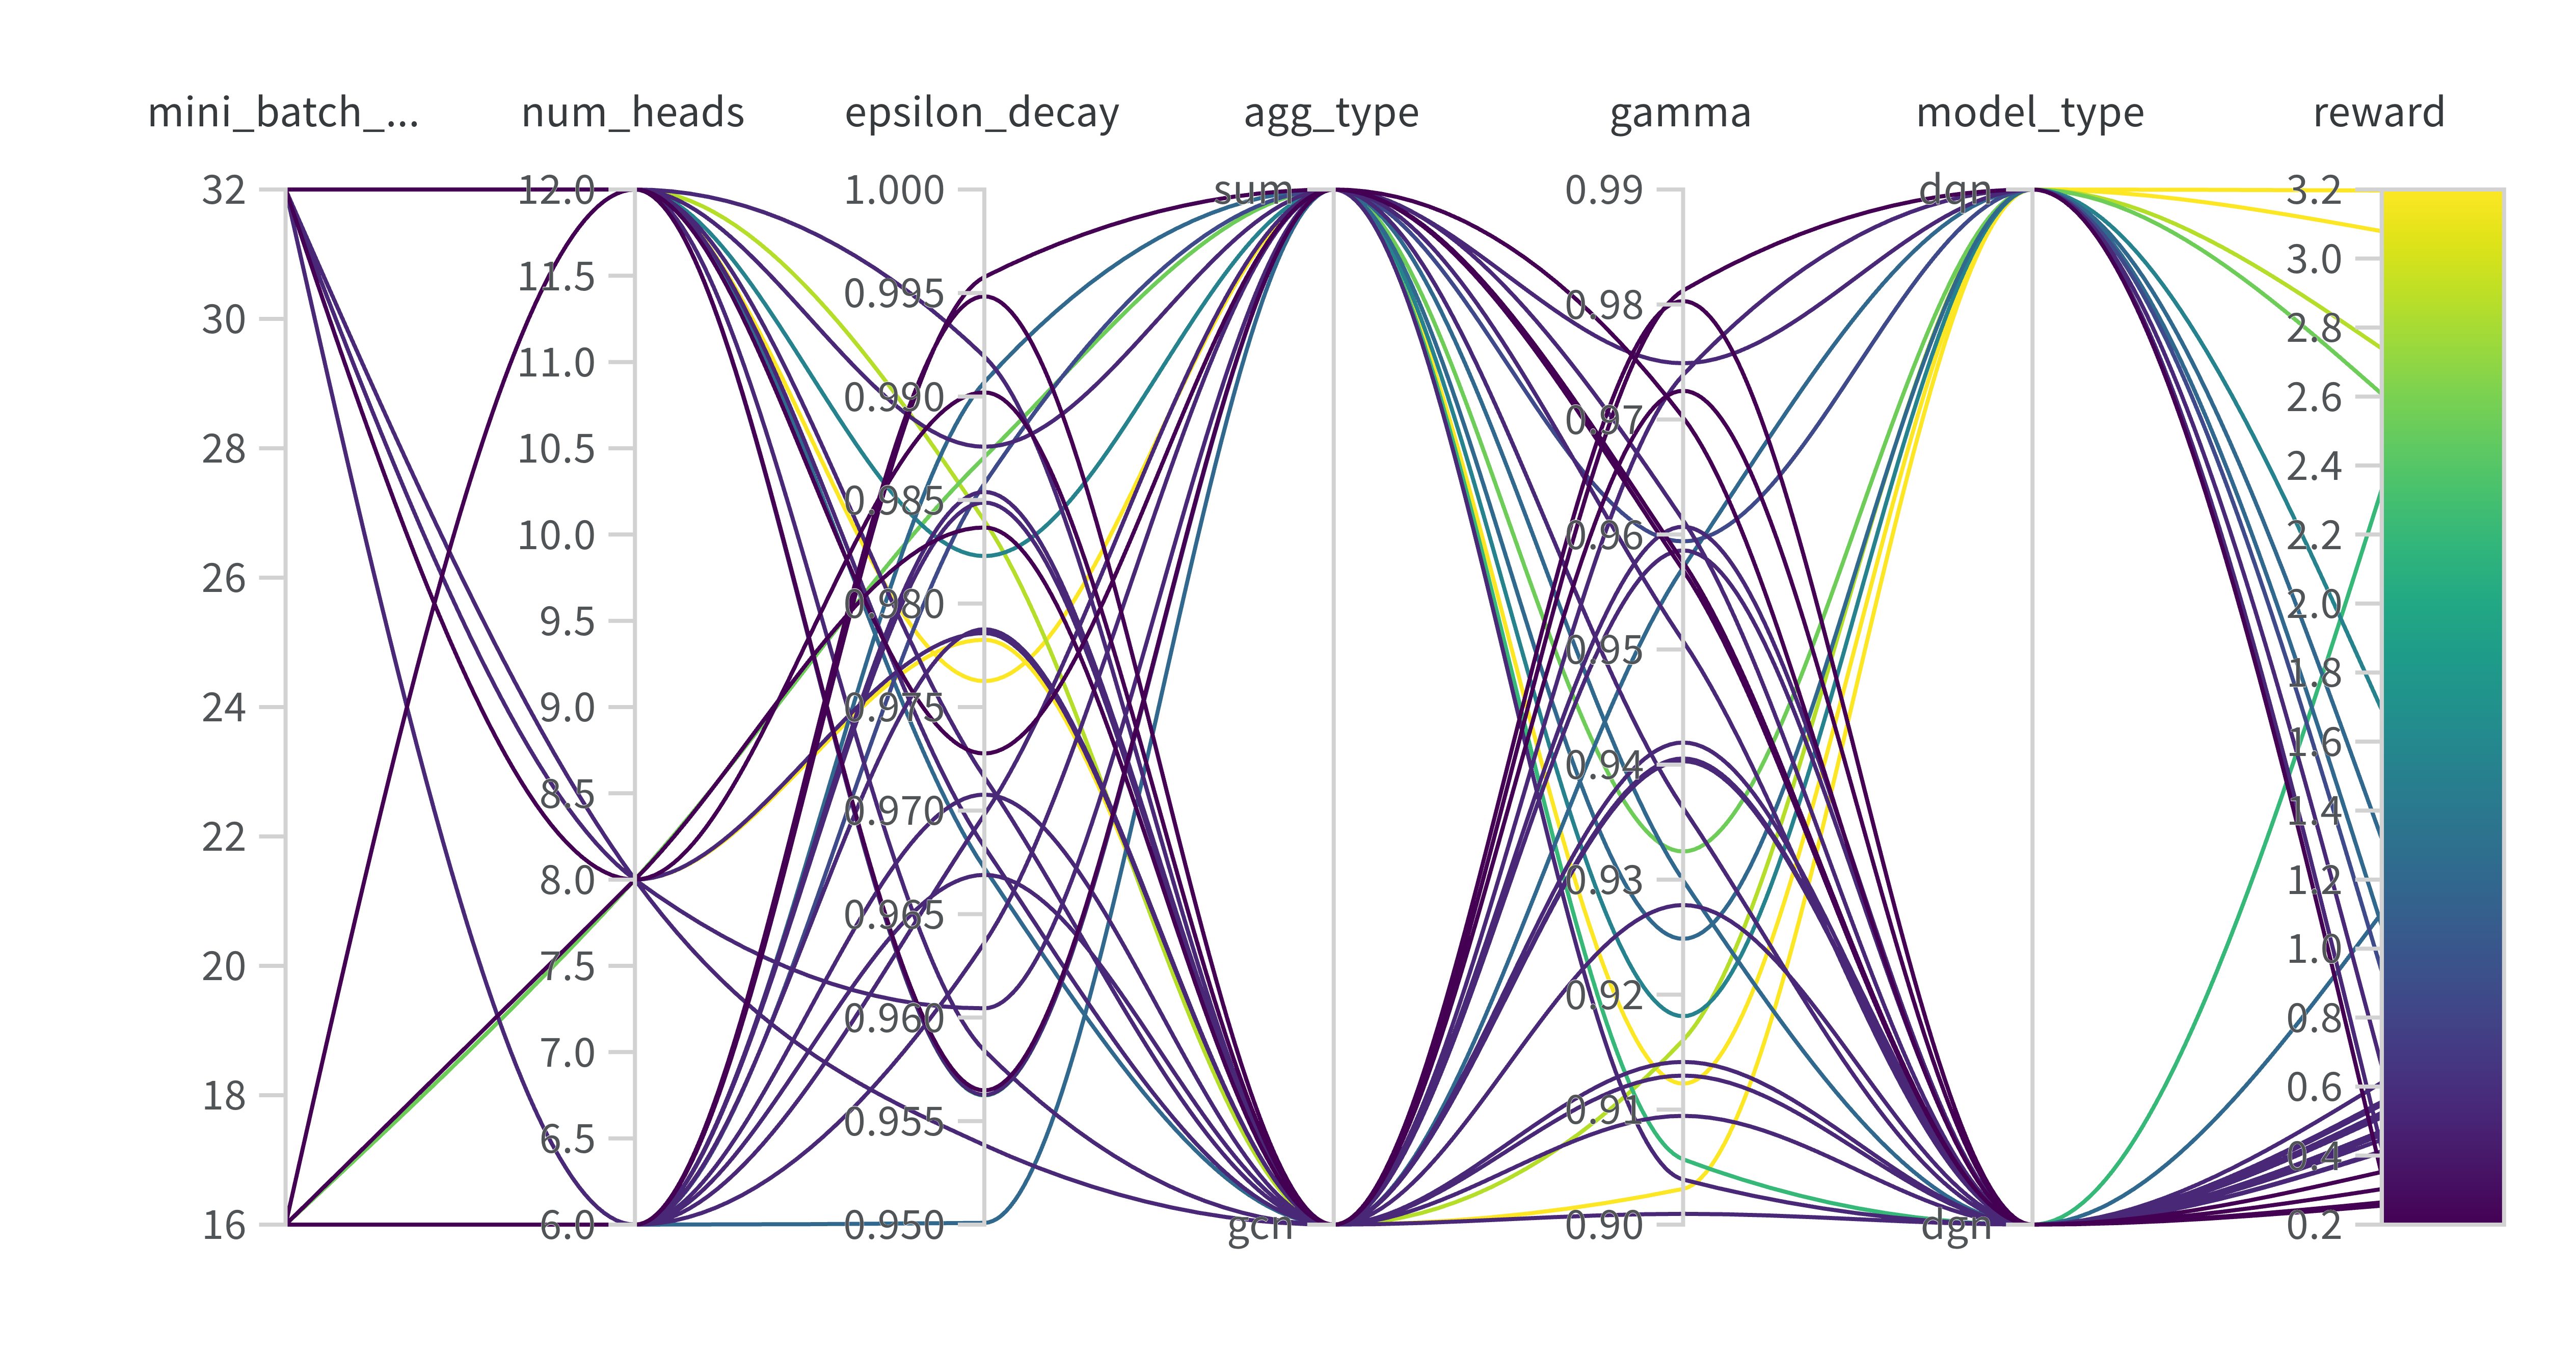

In [18]:
from IPython.display import Image, display
path_commnet = '/content/2024-final-letadylka-prochazka-belohlavek/pictures/commnet.png'

path_dqndgn = '/content/2024-final-letadylka-prochazka-belohlavek/pictures/dgn_dqn.png'
# Display the image
display(Image(filename=path_commnet))
display(Image(filename=path_dqndgn))


# Advice for Parameter Selection
Below we give advice how to fine tune the hyperparameters and then we show results from the sweeps on wandb. 35 sweeps were performed for the two settings.
## CommNet settings
It is apparent that selecting lower number of com_rounds as well as increasing the mini_batch_size improves the model greatly. Although the epsilon_update_frequency does not show as important, it could be due to the narrow range we selected for the sweep. We advice to set this parameter to about 70 for 75k steps and gradually increase this number with increasing number of steps. A good rule of thumb is that after the training the epsilon value should be around 0.01, where there is a hard line so that if epsilon dips below 0.01 it is reset to 0.01.
## DQN, DGN settings
Gamma seemed to be the most important hyperparameter in this setting, which is not all that surprising because of the architecture that goes almost directly into the Q_Net. We saw consistent improvement in the gathered reward with the gamma parameter being set lower (to around 0.92-0,95) for 75k steps. Epsilon update frequency shows here as a very important hyperparameter with a strong negative correlation. This means that epsilon should be updated more often, which suggests that the models are able to learn to navigate the environment quickly. The number of attention heads and attention layers shows a positive correlation with the reward.


## Our results